<a href="https://colab.research.google.com/github/ZAsaee/Image_Segmentation-GastroIntestinal_Tract_Tumor_Detection/blob/main/Notebooks/3_Image_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Packages**

Running Colab with GPU has an issue with the TensorFlow v2.9.1, so I installed v2.8 to run the notebook using GPU. The first two lines of code should be executed before running the notebook, otherwise Colab import TensorFlow v2.9.1.

In [ ]:
!pip install tensorflow==2.8

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import shutil

import imageio
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

random.seed(1)

In [4]:
# Checkout if Colab connects to GPU.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Checkout tensorflow version
tf.__version__

'2.8.0'

In [6]:
# Authorize Google drive connection
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
# Open the folder
%cd /content/gdrive/My Drive/'Springboard_DS_program'/'CP3_Prj'/'Data'

/content/gdrive/My Drive/Springboard_DS_program/CP3_Prj/Data


# **2. Load and Split the Data**

## **2.1. Load the Dataset**

In [9]:
# This folder consists of processed data
image_path = os.path.join('cleaned_data/cropped_images/')
mask_path = os.path.join('cleaned_data/cropped_masks/')

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [10]:
# Check out number of unmasked and masked images in each folder
print(f'number of unmasked images:{len(image_list)}')
print(f'number of masked images:{len(mask_list)}')

number of unmasked images:16590
number of masked images:16590


Let's check out some of unmasked and masked images from the dataset.

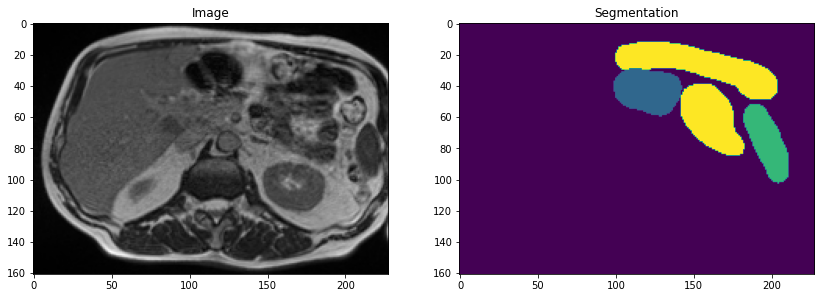

In [11]:
N = 1600
img = cv.imread(image_list[N])
mask = cv.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14,10))
arr[0].imshow(img, cmap='gray')
arr[0].set_title('Image')
arr[1].imshow(cv.cvtColor(mask, cv.COLOR_RGB2GRAY))
arr[1].set_title('Segmentation')
plt.show()

## **2.2. Split Data to Training, Validation and Test**

In [12]:
# Define a function to split data to train, validation and test
def split_data(IMAGE_SOURCE_DIR, MASK_SOURCE_DIR, IMAGE_TRAINING_DIR, MASK_TRAINING_DIR,
               IMAGE_VALIDATION_DIR, MASK_VALIDATION_DIR, IMAGE_TEST_DIR, MASK_TEST_DIR, 
               TRAIN_SIZE, VALID_SIZE, TEST_SIZE):
  """
  Splits the data into train, validation and test sets

  Args:
  IMAGE_SOURCE_DIR(string): directory path containing the unmasked images
  MASK_SOURCE_DIR(string): directory path containing the masked images
  IMAGE_TRAINING_DIR(string): directory path containing training unmasked images
  MASK_TRAINING_DIR(string): directory path containing training masked images
  IMAGE_TVALIDATION_DIR(string): directory path containing validation unmasked images
  MASK_TVALIDATION_DIR(string): directory path containing validation masked images
  IMAGE_TEST_DIR(string): directory path containing test unmasked images
  MASK_TEST_DIR(string): directory path containing test masked images
  TRAIN_SIZE(float): proportion of the dataset to be used for training
  VALID_SIZE(float): proportion of the dataset to be used for validation
  TEST_SIZE(float): proportion of the dataset to be used for test

  Returns: None
  """
  files = []
  for f in os.listdir(IMAGE_SOURCE_DIR):
    file_name = IMAGE_SOURCE_DIR + f
    if os.path.getsize(file_name) > 0:
      files.append(f)
    else:
      print(file_name, ' is zero size, so ignoring!')

  train_len = int(len(files) * TRAIN_SIZE)
  valid_len = int(len(files) * VALID_SIZE)
  test_len = int(len(files) * TEST_SIZE)

  shuffled_set = random.sample(files, len(files))
  train_set = shuffled_set[:train_len]
  valid_set = shuffled_set[train_len:train_len+valid_len]
  test_set = shuffled_set[train_len+valid_len:-1]

  for train_file in train_set:
    image_source_path = IMAGE_SOURCE_DIR + train_file
    mask_source_path = MASK_SOURCE_DIR + train_file
    image_target_path = IMAGE_TRAINING_DIR + train_file
    mask_target_path = MASK_TRAINING_DIR + train_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  for valid_file in valid_set:
    image_source_path = IMAGE_SOURCE_DIR + valid_file
    mask_source_path = MASK_SOURCE_DIR + valid_file
    image_target_path = IMAGE_VALIDATION_DIR + valid_file
    mask_target_path = MASK_VALIDATION_DIR + valid_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)  

  for test_file in test_set:
    image_source_path = IMAGE_SOURCE_DIR + test_file
    mask_source_path = MASK_SOURCE_DIR + test_file
    image_target_path = IMAGE_TEST_DIR + test_file
    mask_target_path = MASK_TEST_DIR + test_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  pass

I define folders and path to those for saving training, validation and test datasets.

In [13]:
# # Create directories to save training, validation and test unmasked and masked datasets
# !mkdir 'cleaned_data/image_training'
# !mkdir 'cleaned_data/mask_training'
# !mkdir 'cleaned_data/image_validation'
# !mkdir 'cleaned_data/mask_validation'
# !mkdir 'cleaned_data/image_test'
# !mkdir 'cleaned_data/mask_test'

In [14]:
# Define directories paths
image_source_dir = os.path.join('cleaned_data/cropped_images/')
mask_source_dir = os.path.join('cleaned_data/cropped_masks/')

image_train_dir = os.path.join('cleaned_data/image_training/')
mask_train_dir = os.path.join('cleaned_data/mask_training/')

image_valid_dir = os.path.join('cleaned_data/image_validation/')
mask_valid_dir = os.path.join('cleaned_data/mask_validation/')

image_test_dir = os.path.join('cleaned_data/image_test/')
mask_test_dir = os.path.join('cleaned_data/mask_test/')

In [15]:
# # Split dataset to train, validation and test
# ##split_data(image_source_dir, mask_source_dir, image_train_dir, mask_train_dir,
#                image_valid_dir, mask_valid_dir, image_test_dir, mask_test_dir, 
#                TRAIN_SIZE=0.7, VALID_SIZE=0.15, TEST_SIZE=0.15)

Let's check the number of images in each folder, and there is no mutual files between those.

In [16]:
# List the files in each directory
image_list = os.listdir(image_source_dir)
mask_list = os.listdir(mask_source_dir)

image_train_list = os.listdir(image_train_dir)
mask_train_list = os.listdir(mask_train_dir)

image_test_list = os.listdir(image_test_dir)
mask_test_list = os.listdir(mask_test_dir)

image_valid_list = os.listdir(image_valid_dir)
mask_valid_list = os.listdir(mask_valid_dir)

image_train_list = [image_train_dir+i for i in image_train_list]
mask_train_list = [mask_train_dir+i for i in mask_train_list]

image_test_list = [image_test_dir+i for i in image_test_list]
mask_test_list = [mask_test_dir+i for i in mask_test_list]

image_valid_list = [image_valid_dir+i for i in image_valid_list]
mask_valid_list = [mask_valid_dir+i for i in mask_valid_list]


In [17]:
# Print number of images in each directory
print(f"\n \n Original image directory has {len(image_list)} images")
print(f"Original mask disrectory has {len(mask_list)} masked images \n")

print(f"There are {len(image_train_list)} unmasked images and {len(mask_train_list)} masked images for training")
print(f"There are {len(image_valid_list)} unmasked images and {len(mask_valid_list)} masked images for validation")
print(f"There are {len(image_test_list)} unmasked images and {len(mask_test_list)} masked images for test")


 
 Original image directory has 16590 images
Original mask disrectory has 16590 masked images 

There are 11613 unmasked images and 11613 masked images for training
There are 2488 unmasked images and 2488 masked images for validation
There are 2488 unmasked images and 2488 masked images for test


In [18]:
print(image_train_list[:3])
print(mask_train_list[:3])
print(image_test_list[:3])
print(mask_test_list[:3])
print(image_valid_list[:3])
print(mask_valid_list[:3])

['cleaned_data/image_training/case7_day13_slice_0071.png', 'cleaned_data/image_training/case33_day0_slice_0121.png', 'cleaned_data/image_training/case34_day16_slice_0029.png']
['cleaned_data/mask_training/case7_day13_slice_0071.png', 'cleaned_data/mask_training/case33_day0_slice_0121.png', 'cleaned_data/mask_training/case34_day16_slice_0029.png']
['cleaned_data/image_test/case89_day19_slice_0085.png', 'cleaned_data/image_test/case144_day0_slice_0066.png', 'cleaned_data/image_test/case89_day20_slice_0084.png']
['cleaned_data/mask_test/case89_day19_slice_0085.png', 'cleaned_data/mask_test/case144_day0_slice_0066.png', 'cleaned_data/mask_test/case89_day20_slice_0084.png']
['cleaned_data/image_validation/case142_day14_slice_0077.png', 'cleaned_data/image_validation/case41_day25_slice_0086.png', 'cleaned_data/image_validation/case81_day28_slice_0090.png']
['cleaned_data/mask_validation/case142_day14_slice_0077.png', 'cleaned_data/mask_validation/case41_day25_slice_0086.png', 'cleaned_data/m

There is no overlap between files in three datasets.

In [19]:
# Check out if there is any duplicate in three categories
print([i for i in image_train_list if i in image_valid_list])
print([i for i in image_test_list if i in image_train_list])
print([i for i in image_test_list if i in image_valid_list])

print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_valid_list])

[]
[]
[]
[]
[]
[]


# **3. Prepare the Dataset**

I define the folder paths to create the inputs for the UNet model.

In [20]:
# Create tensorslice dataset from the datasets
train_image_list_ds = tf.data.Dataset.list_files(image_train_list, shuffle=False)
train_mask_list_ds = tf.data.Dataset.list_files(mask_train_list, shuffle=False)

validation_image_list_ds = tf.data.Dataset.list_files(image_valid_list, shuffle=False)
validation_mask_list_ds = tf.data.Dataset.list_files(mask_valid_list, shuffle=False)

test_image_list_ds = tf.data.Dataset.list_files(image_test_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(mask_test_list, shuffle=False)

Now, the umasked and masked images are zipped together to feed to the UNet model.

In [21]:
for path in zip(train_image_list_ds.take(5), train_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0066.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0066.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0067.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0067.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0069.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0069.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0070.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0070.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0072.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_t

In [22]:
for path in zip(test_image_list_ds.take(5), test_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0071.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0071.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0083.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0083.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0089.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0089.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0093.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0093.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0095.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0095.png'>)


In [23]:
# Create a slice dataset 
train_image_filenames = tf.constant(image_train_list)
train_mask_filenames = tf.constant(mask_train_list)
train = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_mask_filenames))

test_image_filenames = tf.constant(image_test_list)
test_mask_filenames = tf.constant(mask_test_list)
test = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_mask_filenames))

validation_image_filenames = tf.constant(image_valid_list)
validation_mask_filenames = tf.constant(mask_valid_list)
validation = tf.data.Dataset.from_tensor_slices((validation_image_filenames, validation_mask_filenames))

for image, mask in train.take(1):
  print(image)
  print(mask)

for image, mask in test.take(1):
  print(image)
  print(mask)

for image, mask in validation.take(1):
  print(image)
  print(mask)

tf.Tensor(b'cleaned_data/image_training/case7_day13_slice_0071.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_training/case7_day13_slice_0071.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/image_test/case89_day19_slice_0085.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_test/case89_day19_slice_0085.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/image_validation/case142_day14_slice_0077.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_validation/case142_day14_slice_0077.png', shape=(), dtype=string)


## **3.1. Normalize and Resize the Unmasked and Masked Images**

I will now prepare the train, validation and test sets through the following steps:
- normalizing the pixel values
- resizing the images

By using tf.image.convert_image_dtype with tf.float32, we normalize the pixel values and set them between 0 and 1.

In [24]:
# Create functions to normalize and resize the non-masked and masked images
def normalize(image_path, mask_path):
  '''
  normalizes the input image pixel values to be from [0,1]

  image_path: the path to the non-masked images folder
  mask_path: the path to the masked images folder

  return the normalized non-masked image and corresponding non-masked image as tensors
  '''

  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.cast(img, tf.float32) / 255.0

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.cast(tf.image.convert_image_dtype(mask, tf.float32)*3, tf.int16)
  
  return img, mask

def resize(image, mask):
  '''
  resizes the unmasked and masked images to (128, 128)

  image: unmasked image
  mask: masked image
  '''
  input_image = tf.image.resize(image, (96, 128), method='nearest')
  input_mask = tf.image.resize(mask, (96, 128), method='nearest')

  return input_image, input_mask

In [25]:
# Normalize and resize the train, validation and test dataset
train_ds = train.map(normalize)
train_processed_ds = train_ds.map(resize)

validation_ds = validation.map(normalize)
validation_processed_ds = validation_ds.map(resize)

test_ds = test.map(normalize)
test_processed_ds = test_ds.map(resize)

Let's check out the images after resizing and normalizing operations.

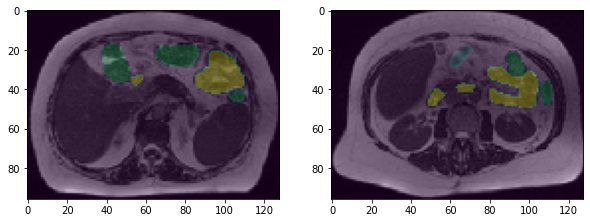

In [26]:
plt.figure(figsize=(10,16))
n = 1
for i, j in validation_processed_ds.take(2):
  plt.subplot(4,2,n)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(i))
  n += 1
  plt.imshow(tf.keras.preprocessing.image.array_to_img(j), alpha=0.3)
  # plt.colorbar()

plt.show()

# **4. U-Net Model**

## **4.1. U-Net Architecture Details**

U-Net architecture (named for its U-shape as shown below) was originally introduced in 2015 for the tumor detection research. However, this model has become a very popular choice for image segmentation tasks.

U-Net architecture is based on the Fully Conventional Network (FCN) and replace the dense layers (usually part of a typical CNN) with a transposed convolution layer to upsample the feature map back to the size of original input image, while preserving the spatial information. This is an essential characteristic of the U-Net for image segmentation, since the dense layers destroy spatial information. The main issue with FCN is that its final feature layer suffers from information loss due to too much downsampling. Therefore, it becomes difficult to upsample after losing so much information and causing an output that looks rough. 

U-Net addressed the FCN issue using a similar design but with some important modifications. Instead of one transposed convolution at the end of the network, U-Net uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original inut image size. U-Net also adds skip connections between downsampling and upsampling blocks to retain information and avoid losing information during encoding. Skip connections send information from the downsampling layer in encoder to the upsampling layers in decoder. These skip connections capture finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

The images are fed through several convolution layers to reduce height and width, while increasing their channels. A U-Net consists of encoder (downsampler) and decoder (upsampler) with a bottleneck in between. 

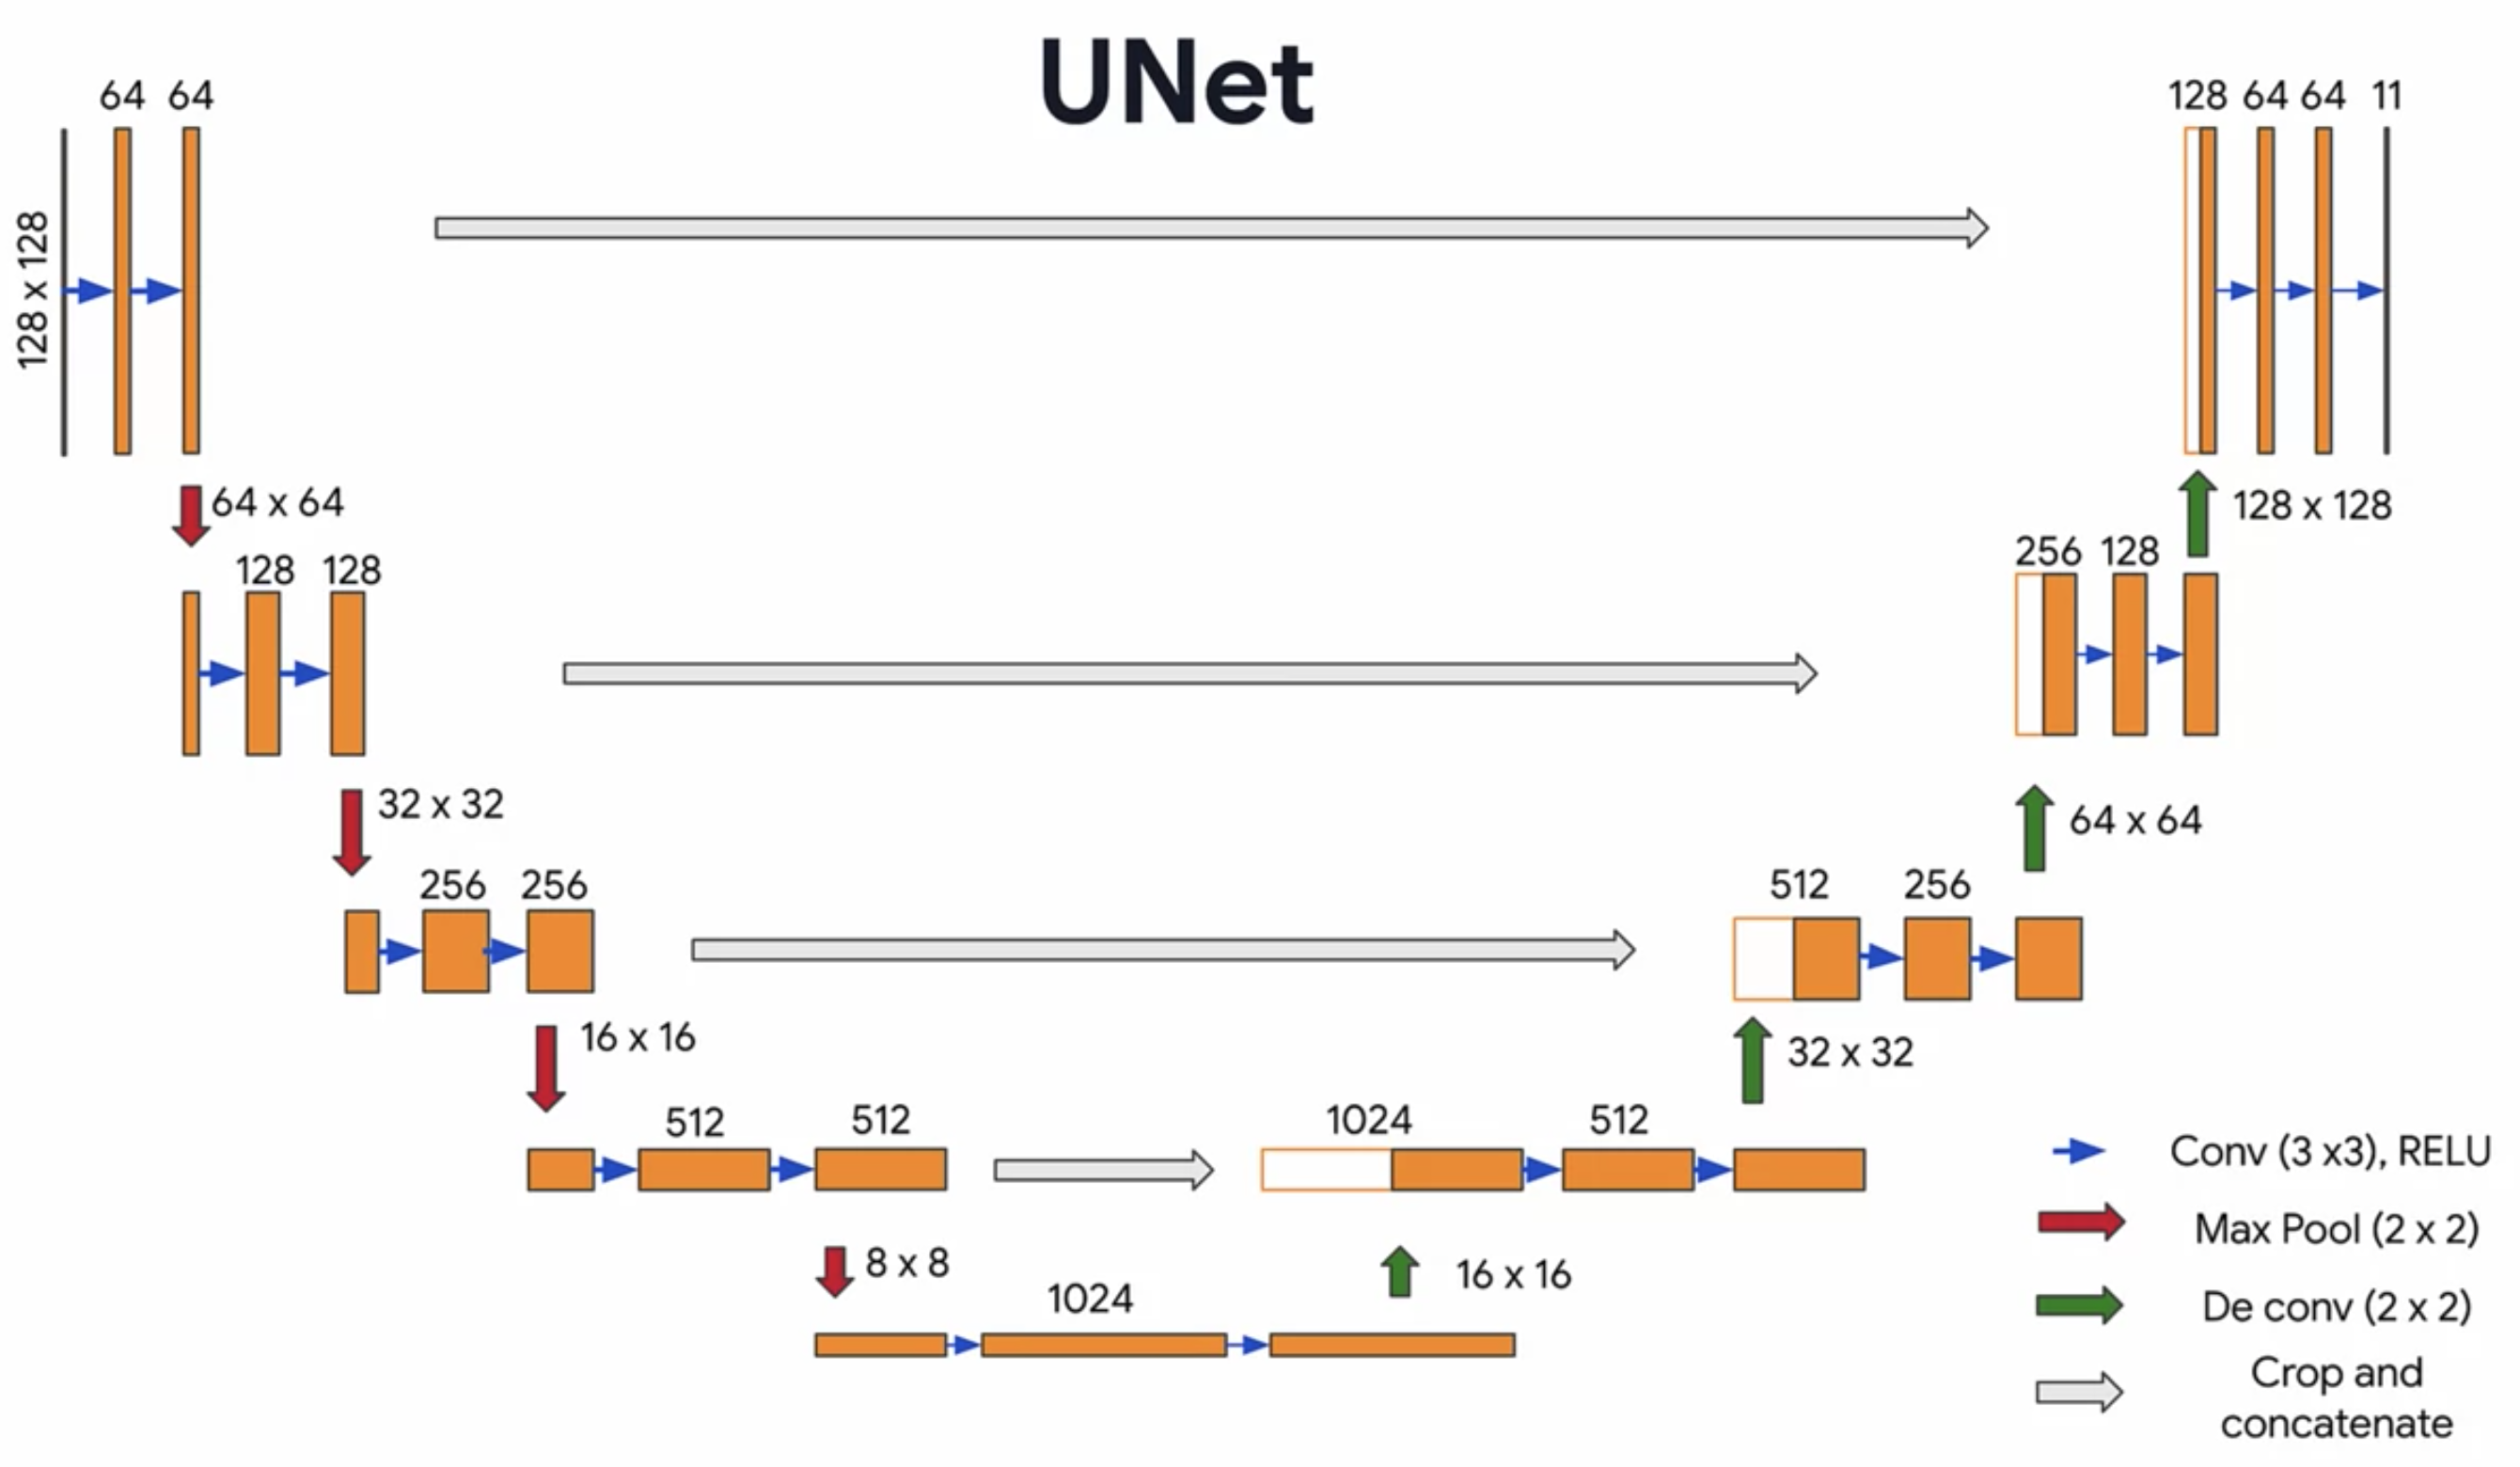





## **4.1. Downsampling Blocks (Encoder)**

The downsampling blocks (encoder) follow a regular CNN architecture including convolutional layers followed by their activation, max pooling layers to downsample the image and extract features. Each block consists of two 3x3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. The number of feature channels are doubled at each step. At each step of encoder, a skip connection is created by cropping the image from the downsampling path and concatenates it to the current image on the upsampling path.



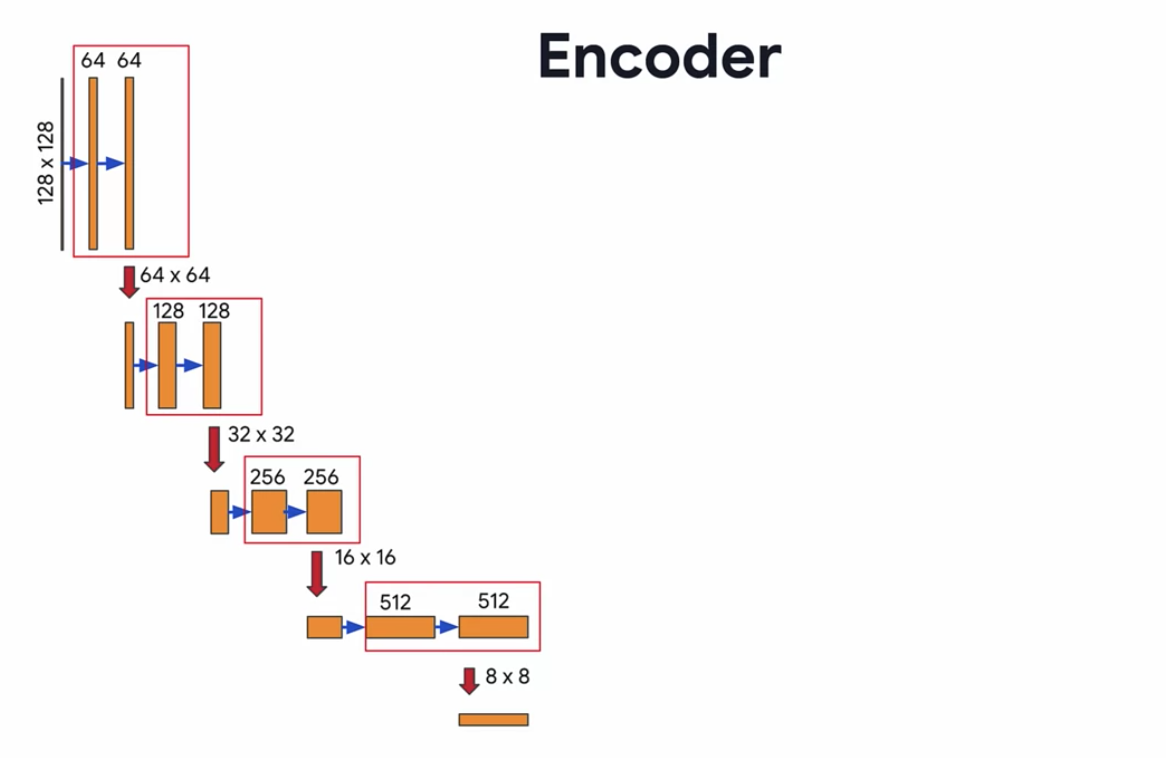

I define three functions to create the encoder path:



*   conv2d_block(): two convolutional layers with ReLU activation functions
*   encode_block(): conv2d blocks with pooling and dropout layers. The output of this function is two parameters including the output of the dropout as the input of next block, and the output of conv2d block for the skip connection.
* encodr(): put it together and build the whole encoder path



In [27]:
# Encoder Part

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  input_tensor: the input tensor
  n_filters: number of filters
  kernel size: kernel size for the convolution

  Return:
  tensor of output feature
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  inputs: the input tensor
  n_filters: number of filters
  kernel_size: kernel size for convolution

  returns:
  f: the output features of the convolution block
  p: the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

def encoder(inputs):
  '''
  defines the encoder or downsampling path

  inputs: batch of input images

  return:
  p4: the output of maxpooled features of the last encoder block
  (f1, f2, f3, f4): the output features of all encoder blocks
  '''

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

## **4.2. Bottleneck Block**

A bottleneck path follows the encoder block and its main purpose is to extract more features. The bottleneck path does not include any max pooling layer, therefore the dimensionality remains the same. conv2d_block can be used to implement this path.

In [28]:
def bottleneck(inputs):
  '''
  defins the bottleneck convolution to extract more features before the upsampling layers
  '''
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

## **4.3. Decore Block (Upsampling)**

The upsampling path performs opposite of the downsampling path and grows the image back to its original size while shrinking the channels gradually. In the upsampling path, the output of the corresponding encoder block is concatenated before feeding to the next encoer block. The encoder path consists of two main components of transpose convolution and skip connections


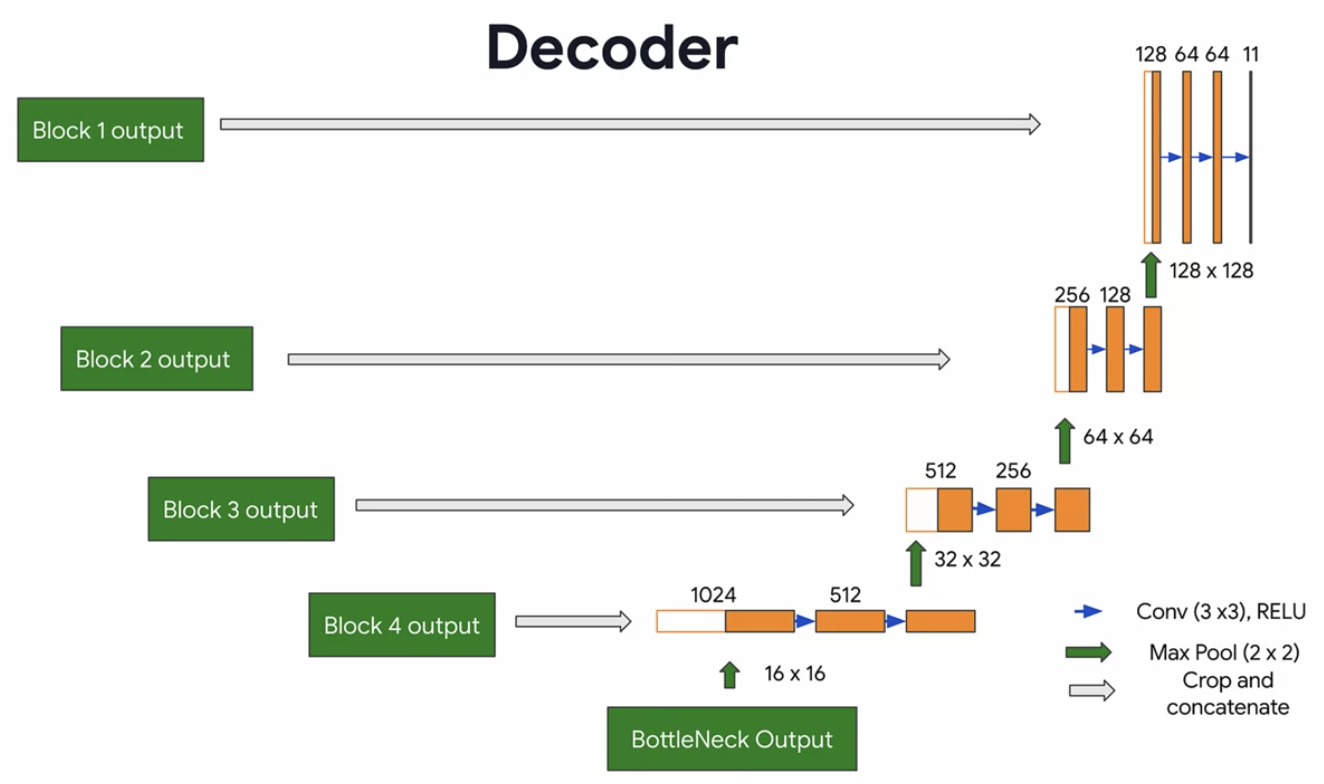

In [29]:

# Decoder Part

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  define the decoder block of the UNet

  inputs: batch of input features
  conv_output: features from an encoder block
  n_filters: number of filters
  kernel_size: kernel size
  strides: strides for deconvolution/upsampling
  padding: "same" or "valid"

  return:
  c: output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c

def decoder(inputs, convs, output_channels):
  '''
  define the decoder of UNet containing four decoder blocks

  inputs: batch of input features
  convs: features from the encoder blocks
  ouput_channels: number of classes in the label map

  return:
  outputs: the pixel wise label map of the image

  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), padding='same', activation='softmax')(c9)

  return outputs


## **4.4. Build the U-Net Model**

I create the U-Net model by putting it all together, and chaining the encoder, bottleneck and decoder.

In [30]:
# number of output channels are equal to the number of classes
OUTPUT_CHANNELS = 4

def unet():
  '''
  connect encoder, bottleneck and decoder to form UNet
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(96,128,3))

  # feed the inputs to the encoder
  encoder_ouput, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_ouput)

  # feed the bottleneck and encoder outputs to the decoder
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [31]:
# instantiate the model
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 96, 128, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 64)  36928       ['activation[0][0]']         

## **4.5. Compile and Train the Model**

In [32]:
# define the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# STEPS_PER_EPOCH = len(image_train_list) // BATCH_SIZE
# VALIDATION_STEPS = len(image_valid_list) // BATCH_SIZE // VAL_SUBSPLITS

# shuffle and group the train set to batches
train_dataset = train_processed_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the validation set to batches
validation_dataset = validation_processed_ds.batch(BATCH_SIZE)

In [34]:
# set the callback to stop training the model when reached 99% accuracy

class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.99):
                print("\nReached 99% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [35]:
# fit the model
callbacks = myCallback()

with tf.device('/gpu:0'):
  model_history = model.fit(train_dataset, epochs=EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=callbacks)


Epoch 1/20
363/363 [==============================] - 781s 2s/step - loss: 2.3975 - accuracy: 0.9326 - val_loss: 0.1616 - val_accuracy: 0.9429
Epoch 2/20
363/363 [==============================] - 72s 199ms/step - loss: 0.1380 - accuracy: 0.9493 - val_loss: 0.1142 - val_accuracy: 0.9573
Epoch 3/20
363/363 [==============================] - 72s 199ms/step - loss: 0.1098 - accuracy: 0.9590 - val_loss: 0.0951 - val_accuracy: 0.9641
Epoch 4/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0907 - accuracy: 0.9658 - val_loss: 0.0806 - val_accuracy: 0.9696
Epoch 5/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0780 - accuracy: 0.9704 - val_loss: 0.0688 - val_accuracy: 0.9735
Epoch 6/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0698 - accuracy: 0.9735 - val_loss: 0.0653 - val_accuracy: 0.9752
Epoch 7/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0648 - accuracy: 0.9755 - val_loss: 0.0563 - val_accu

In [36]:
## create a directory to save the model
# !mkdir '/content/gdrive/MyDrive/Springboard_DS_program/CP3_Prj/Model/unet_rev1'

In [37]:
## save the model
model.save('/content/gdrive/MyDrive/Springboard_DS_program/CP3_Prj/Model/unet_rev1/')

## **4.6. Plot the Model Accuracy**

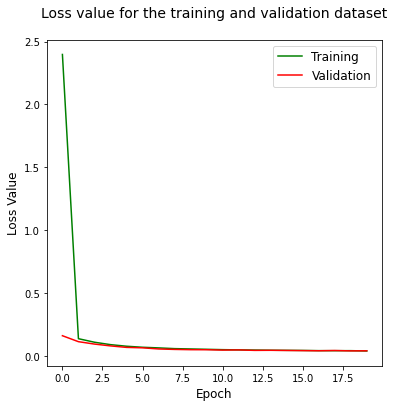

In [64]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["loss"], color='g', label='Training')
plt.plot(model_history.history["val_loss"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Loss value for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()

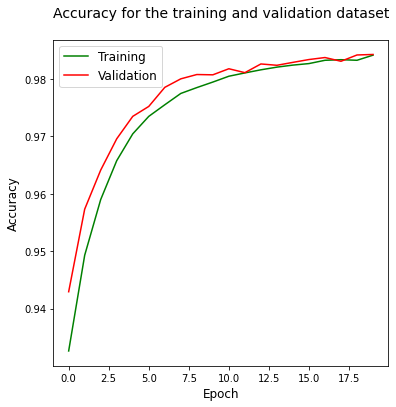

In [65]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["accuracy"], color='g', label='Training')
plt.plot(model_history.history["val_accuracy"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()

## **4.7. Make Predictions**

I feed the test dataset into the model and predict the mask of images. In order to do it, I define some functions for prediction and displaying it.

In [68]:
def create_mask(pred_mask):
  '''
  creates the segmentation mask by getting the channel with the highest probability. 
  I have four channels in the output of U-Net. 
  The prediction of each pixel is the channel with the highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(model, image):
  '''
  inputs an image to the model and predicts the mask
  '''
  image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

## **4.8. Compute Prediction Metrics**

I use Intersection of Union (IOU) and Dice Score to evaluate the prediction.

\begin{align}
    IOU = \frac{Area \, of \, overlap}{Area \, of \, union}
\end{align}


\begin{align}
    Dice Score = IOU = \frac{2 * Area \, of \, overlap}{Total \, area \, of \, both \, images}
\end{align}
  


In [192]:
def class_metrics(y_true, y_pred, n_classes):
  class_iou = []
  class_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothing_factor) / (combined_area - intersection + smoothing_factor)
    class_iou.append(iou)

    dice_score = 2 * (intersection + smoothing_factor) / (combined_area + smoothing_factor)
    class_dice_score.append(dice_score)

  return class_iou, class_dice_score

def metrics_eval(dataset):
  n = len(list(dataset))
  iou_score = []
  dice_score = []
  for image, true_mask in dataset.take(n):
    results = model.predict(np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2])))
    results = np.argmax(results, axis=3)
    results = results[..., tf.newaxis]
    iou, dice = class_metrics(true_mask.numpy(), results, 4)
    
    iou_score.append(iou)
    dice_score.append(dice)

  avg_iou = []
  avg_dice = []

  for label in range(4):
    avg_iou.append(sum([iou_score[i][label] for i in range(len(iou_score))])/len(iou_score))
    avg_dice.append(sum([dice_score[i][label] for i in range(len(dice_score))])/len(dice_score))  
  
  return iou_score, dice_score, avg_iou, avg_dice

In [193]:
def display(dataset, num):
  '''
  plots the image, ground truth mask and predicted mask.
  display_list consists of input image, true mask and predicted mask
  '''
  for image, mask in dataset.take(num):
    image = image
    true_mask = mask
  display_list = [image, true_mask, make_predictions(model, image)]
  plt.figure(figsize=(15, 15))
  label = ['Stomach', 'Large Bowel', 'Small Bowel']

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  dice = metrics_eval(dataset.take(num))[1][-1]
  iou =  metrics_eval(dataset.take(num))[0][-1]

  string = '\n' + label[0]+' -- '+ 'dice score: ' + str(np.round(dice[1],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[1],4)) + ' \n \n' + \
           label[1]+' -- '+ 'dice score: ' + str(np.round(dice[2],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[2],4)) + ' \n \n' + \
           label[2]+' -- '+ 'dice score: ' + str(np.round(dice[3],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[3],4)) + ' \n \n' 


  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(title[i], fontsize=14)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    # plt.axis('off')
  plt.xlabel(string, x =-0.7, y=3, fontsize=20)
  plt.show()

Let's display some of the predictions for the training, validation and test data.

Training data 



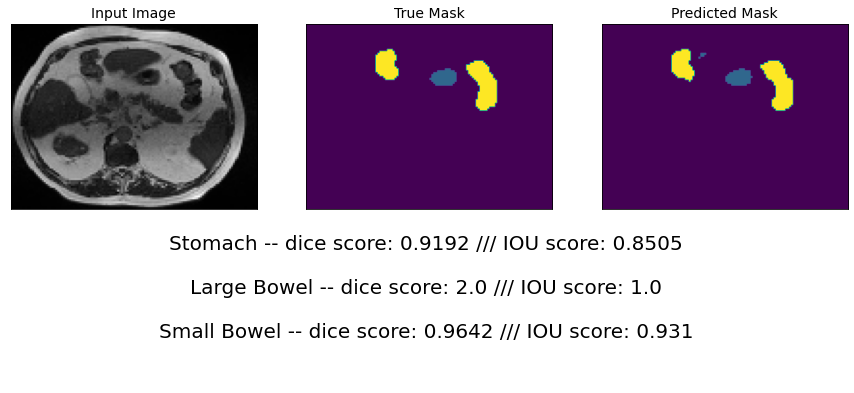

In [194]:
print('Training data \n')
display(train_processed_ds, 1)

Validation data 



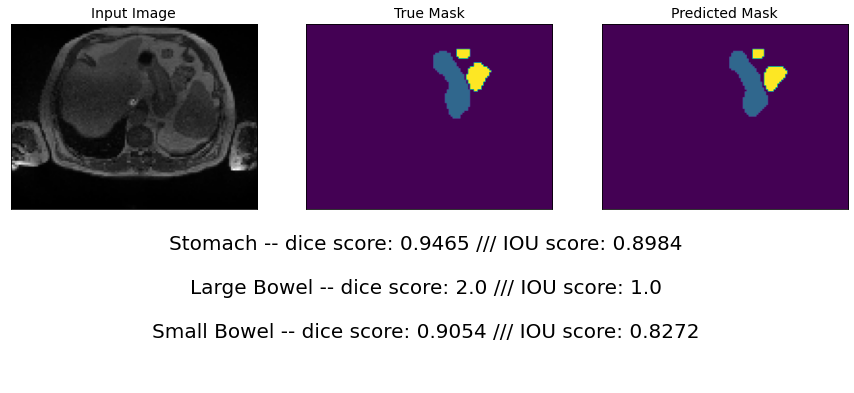

In [195]:
print('Validation data \n')
display(validation_processed_ds, 100)

Test data 



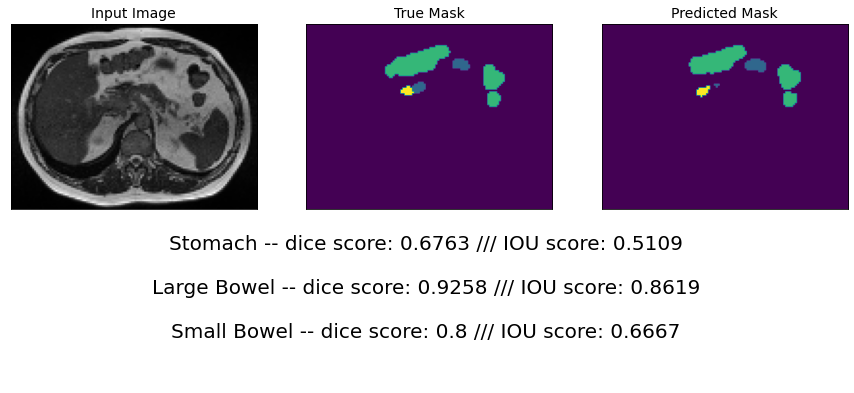

In [196]:
print('Test data \n')
display(test_processed_ds, 100)

Test data 



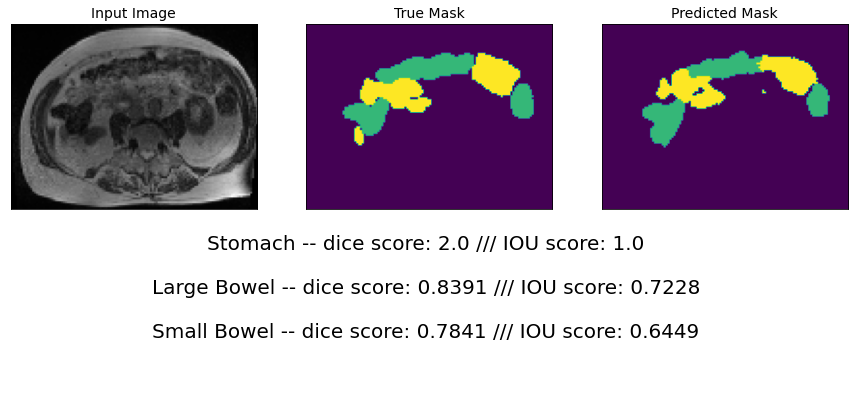

In [197]:
print('Test data \n')
display(test_processed_ds, 620)

Test data 



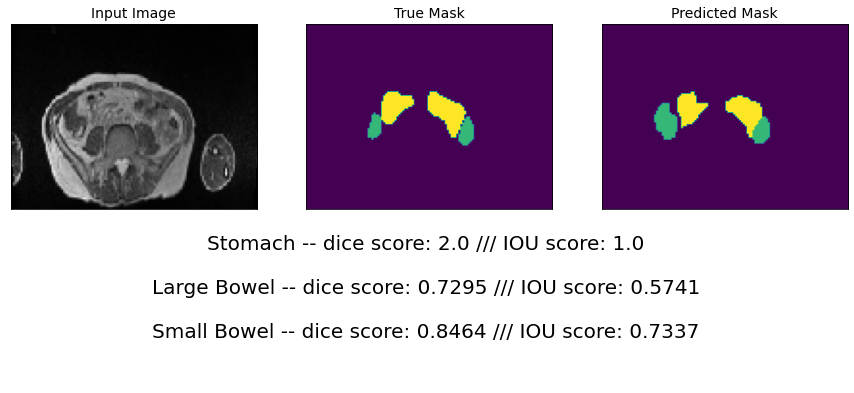

In [198]:
print('Test data \n')
display(test_processed_ds, 1000)

In [219]:
iou_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
iou_results.head()

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel


In [200]:
iou_score_train, dice_score_trian, avg_iou_train, avg_dice_train = metrics_eval(train_processed_ds)

In [202]:
iou_score_validation, dice_score_validation, avg_iou_validation, avg_dice_validation = metrics_eval(validation_processed_ds)

In [203]:
iou_score_test, dice_score_test, avg_iou_test, avg_dice_test = metrics_eval(test_processed_ds)

In [220]:
iou_results.loc['Training Dataset - IOU Score'] = avg_iou_train
iou_results.loc['Validation Dataset - IOU Score'] = avg_iou_validation
iou_results.loc['Test Dataset - IOU Score'] = avg_iou_test
iou_results

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel
Training Dataset - IOU Score,0.986350,0.897117,0.847725,0.728280
Validation Dataset - IOU Score,0.985567,0.866299,0.816387,0.682153
Test Dataset - IOU Score,0.985123,0.878671,0.813626,0.689883


In [222]:
dice_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
dice_results.loc['Training Dataset - Dice Score'] = avg_dice_train
dice_results.loc['Validation Dataset - Dice Score'] = avg_dice_validation
dice_results.loc['Test Dataset - Dice Score'] = avg_dice_test
dice_results

,Label-Background,Label-Stomach,Label-Large Bowel,Label-Small Bowel
Training Dataset - Dice Score,0.993108,1.520167,1.212187,0.824408
Validation Dataset - Dice Score,0.992709,1.457328,1.184123,0.782533
Test Dataset - Dice Score,0.992481,1.511207,1.157180,0.792856
